## KNN Implemented using sklearn + K-Fold Cross-validation and GridSearchCV for Hyperparameter Tuning
___

**Dataset**: Penguins

In [13]:
#  SK-learn implementation of KNN + K-Fold

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [14]:
penguins = sns.load_dataset('penguins').dropna()

In [15]:
le = LabelEncoder()  # Encode categorical data in a numerical format
penguins['sex'] = le.fit_transform(penguins['sex'])
penguins['species'] = le.fit_transform(penguins['species'])
penguins['island'] = le.fit_transform(penguins['island'])

X = penguins.drop('species', axis=1)  # Get Features 
y = penguins['species']  # Get labels

scaler = StandardScaler()  # Scale the feature data 
scaler.fit(X)
X_scaled = scaler.transform(X)

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [18]:
model = KNeighborsClassifier(n_neighbors=5)  # Create a KNN model
model.fit(X_train, y_train)  # Fit the model to the training data
y_pred = model.predict(X_test)  # Get a predictions vector

In [19]:
# Evaluate model accuracy based on metrics included within SK-learn

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cf_matrix)

Accuracy: 0.9818181818181818
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.95      0.95      0.95        20
           2       1.00      1.00      1.00        38

    accuracy                           0.98       110
   macro avg       0.98      0.98      0.98       110
weighted avg       0.98      0.98      0.98       110

Confusion Matrix:
 [[51  1  0]
 [ 1 19  0]
 [ 0  0 38]]


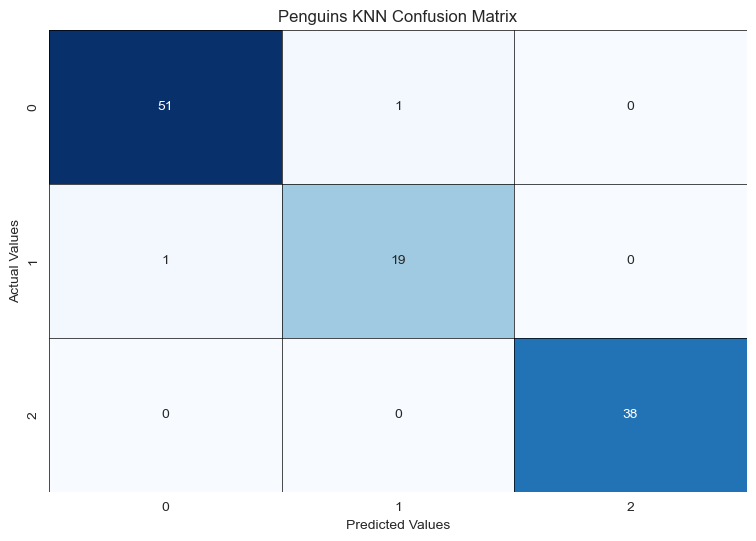

In [20]:
# Plot the Confusion Matrix

plt.figure(figsize = (9, 6))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

ax.set_title('Penguins KNN Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

num_rows, num_cols = cf_matrix.shape  # Get the number of rows and columns

# Draw horizontal lines
for i in range(num_rows + 1):
    ax.axhline(y=i, color='black', linewidth=0.5)

# Draw vertical lines
for j in range(num_cols + 1):
    ax.axvline(x=j, color='black', linewidth=0.5)

plt.show()

## K-Fold Cross Validation
___
K-fold cross-validation is a powerful technique used to evaluate the performance of machine learning models, including KNN classifiers, by providing a more robust estimate of model performance on unseen data. Here's how it works:

1. The dataset is divided into K equally sized folds while maintaining the proportion of classes in each fold (stratified sampling).

2. The model is trained and evaluated K times, with each fold serving as the test set exactly once while the remaining K-1 folds are used for training.

3. Performance metrics are calculated for each iteration, and the final model performance is determined by averaging these results.

#### Process

1. Choose the number of folds (K), typically 5 or 10.
2. Split the dataset into K folds.
3. For each iteration:
   - Use K-1 folds for training
   - Use the remaining fold for testing
   - Train the model and evaluate its performance
4. Calculate the average performance across all K iterations.

#### Benefits

1. Provides a more reliable estimate of model performance by using all data for both training and testing.
2. Reduces the impact of data variability and minimizes the risk of overfitting to a particular data split.
3. Especially useful for smaller datasets, as it makes efficient use of limited data.

Below, we implement K-Fold Cross Validation on our KNN model.

In [21]:
# Conduct K-Fold Cross Validation

# Define the number of folds
k_folds = 5

# Create a KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Empty lists to store accuracy scores
accuracy_scores = []

# Loop through each fold
for train_index, test_index in kf.split(X_scaled):
    # Split data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the KNN model on the training set for this fold
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the testing set for this fold
    y_pred = model.predict(X_test_fold)

    # Calculate accuracy score for this fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(accuracy)

# Print the average accuracy across all folds
print(f"Average accuracy across {k_folds} folds: {np.mean(accuracy_scores)}")

Average accuracy across 5 folds: 0.9909543193125282


## Finding Optimal Hyperparameter K with Grid Search
___

Determining the optimal hyperparameter K for K-nearest neighbors (KNN) using Grid Search involves systematically evaluating the model's performance across a range of K values. Here's a conceptual and mathematical explanation of the process:

#### Conceptual Overview

1. Define a range of K values to test
2. For each K value:
   - Train the KNN model
   - Evaluate its performance using cross-validation
3. Select the K that yields the best performance

#### Mathematical Foundation

Let's define:
- $X$ as the feature set
- $y$ as the target variable
- $K = \{k_1, k_2, ..., k_n\}$ as the set of K values to test

For each $k_i \in K$:

1. Train the KNN model:
   $f_{k_i}(x) = \text{mode}(y_j | (x_j, y_j) \in N_{k_i}(x))$
   where $N_{k_i}(x)$ is the set of $k_i$ nearest neighbors of $x$

2. Perform cross-validation:
   - Split the data into $m$ folds
   - For each fold $j$:
     $Accuracy_{k_i,j} = \frac{1}{|X_j|} \sum_{x \in X_j} I(f_{k_i}(x) = y_x)$
     where $X_j$ is the test set for fold $j$, and $I$ is the indicator function

3. Calculate the mean cross-validation score:
   $CV_{k_i} = \frac{1}{m} \sum_{j=1}^m Accuracy_{k_i,j}$

4. Select the optimal K:
   $K_{optimal} = \text{argmax}_{k_i \in K} CV_{k_i}$

In [22]:
#  Utilize GridSearchCV to find the best hyperparameter K

param_grid = {'n_neighbors': range(1, 31)}  # Testing k from 1 to 30

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the gridsearch model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'n_neighbors': 5}
Best cross-validation score: 0.9954545454545455
